In [1]:
import IJulia

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

fig_width = 7
fig_height = 5
fig_format = :retina
fig_dpi = 96

# no retina format type, use svg for high quality type/marks
if fig_format == :retina
  fig_format = :svg
elseif fig_format == :pdf
  fig_dpi = 96
  # Enable PDF support for IJulia
  IJulia.register_mime(MIME("application/pdf"))
end

# convert inches to pixels
fig_width = fig_width * fig_dpi
fig_height = fig_height * fig_dpi

# Intialize Plots w/ default fig width/height
try
  import Plots

  # Plots.jl doesn't support PDF output for versions < 1.28.1
  # so use png (if the DPI remains the default of 300 then set to 96)
  if (Plots._current_plots_version < v"1.28.1") & (fig_format == :pdf)
    Plots.gr(size=(fig_width, fig_height), fmt = :png, dpi = fig_dpi)
  else
    Plots.gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
  end
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# Initialize CairoMakie with default fig width/height
try
  import CairoMakie
  
  CairoMakie.activate!(type = string(fig_format))
  CairoMakie.update_theme!(resolution=(fig_width, fig_height))
catch e
    # @warn "CairoMakie init" exception=(e, catch_backtrace())
end
  
# Set run_path if specified
try
  run_path = raw""
  if !isempty(run_path)
    cd(run_path)
  end
catch e
  @warn "Run path init:" exception=(e, catch_backtrace())
end


# emulate old Pkg.installed beahvior, see
# https://discourse.julialang.org/t/how-to-use-pkg-dependencies-instead-of-pkg-installed/36416/9
import Pkg
function isinstalled(pkg::String)
  any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
end

# ojs_define
if isinstalled("JSON") && isinstalled("DataFrames")
  import JSON, DataFrames
  global function ojs_define(; kwargs...)
    convert(x) = x
    convert(x::DataFrames.AbstractDataFrame) = Tables.rows(x)
    content = Dict("contents" => [Dict("name" => k, "value" => convert(v)) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
elseif isinstalled("JSON")
  import JSON
  global function ojs_define(; kwargs...)
    content = Dict("contents" => [Dict("name" => k, "value" => v) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
else
  global function ojs_define(; kwargs...)
    @warn "JSON package not available. Please install the JSON.jl package to use ojs_define."
  end
end


# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


In [2]:
#| warning: false
#| output: false

using DataFrames

function expand_grid(; iters...)
    var_names = collect(keys(iters))
    var_itr = [1:length(x) for x in iters.data]
    var_ix = vcat([collect(x)' for x in Iterators.product(var_itr...)]...)
    out = DataFrame()
    for i = 1:length(var_names)
        out[:,var_names[i]] = collect(iters[i])[var_ix[:,i]]
    end
    return out
end

d = expand_grid(iteration=1:3, Possibilities=["A", "B","C", "D"], stage = ["Prior", "Posterior"])

d2 =DataFrame(Credibility =[fill(.25,4); 0; fill(1/3,3); 0; fill(1/3,3);0;.5;0;0.5;0;.5;0;0.5;fill(0,3);1])

sort!(d, [:iteration])
d.Credibility = d2.Credibility

┌ Warning: use values(kwargs) and keys(kwargs) instead of kwargs.data and kwargs.itr
│   caller = expand_grid(; iters::Base.Pairs{Symbol, AbstractVector, Tuple{Symbol, Symbol, Symbol}, NamedTuple{(:iteration, :Possibilities, :stage), Tuple{UnitRange{Int64}, Vector{String}, Vector{String}}}}) at In[2]:6
└ @ Main ./In[2]:6


24-element Vector{Float64}:
 0.25
 0.25
 0.25
 0.25
 0.0
 0.3333333333333333
 0.3333333333333333
 0.3333333333333333
 0.0
 0.3333333333333333
 0.3333333333333333
 0.3333333333333333
 0.0
 0.5
 0.0
 0.5
 0.0
 0.5
 0.0
 0.5
 0.0
 0.0
 0.0
 1.0

In [3]:
first(d,5)

,iteration,Possibilities,stage,Credibility
,Int64,String,String,Float64
1,1,A,Prior,0.25
2,1,B,Prior,0.25
3,1,C,Prior,0.25
4,1,D,Prior,0.25
5,1,A,Posterior,0.0


┌ Warning: `@where is deprecated, use `@subset` instead.
└ @ DataFramesMeta /Users/kiantefernandez/.julia/packages/DataFramesMeta/BkRtJ/src/macros.jl:949
┌ Warning: `@where is deprecated, use `@subset` instead.
└ @ DataFramesMeta /Users/kiantefernandez/.julia/packages/DataFramesMeta/BkRtJ/src/macros.jl:949


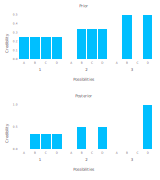

In [4]:
#| warning: false
#| echo: false

using Gadfly
using DataFramesMeta

#Specify the plot size
set_default_plot_size(16cm, 18cm)

df_Prior = @where(d, :stage .== "Prior")
df_Posterior = @where(d, :stage .== "Posterior")

fig1a = plot(df_Prior,
    xgroup = :iteration,
    x = :Possibilities,
    y = :Credibility,
    Geom.subplot_grid(Geom.bar(orientation = :vertical),
    Guide.xlabel(orientation= :horizontal),
    Guide.xticks(orientation = :horizontal)),
    Guide.xlabel("Possibilities"),
    Guide.ylabel("Credibility"),
    Guide.title("Prior"),
    Scale.y_continuous(format = :plain),
    Theme(
        background_color = "white",
        bar_spacing = 1mm,
        grid_color = "white"
    )
)
fig1b = plot(df_Posterior,
    xgroup = :iteration,
    x = :Possibilities,
    y = :Credibility,
    Geom.subplot_grid(Geom.bar(orientation = :vertical),
    Guide.xlabel(orientation= :horizontal),
    Guide.xticks(orientation = :horizontal)),
    Guide.xlabel("Possibilities"),
    Guide.ylabel("Credibility"),
    Guide.title("Posterior"),
    Scale.y_continuous(format = :plain),
    Theme(
        background_color = "white",
        bar_spacing = 1mm,
        grid_color = "white"
    )
)
#create a subplot
vstack(fig1a,fig1b)

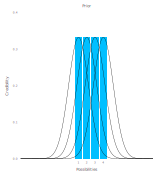

In [5]:
using Gadfly
using Distributions
using DataFrames

set_default_plot_size(16cm, 18cm)

ticks = [1, 2, 3, 4] #specify the tick marks

#create some data for the bars
x5 = DataFrame(Possibilities = 1, Credibility = pdf(Normal(1, 1.2), 1))
x6 = DataFrame(Possibilities = 2, Credibility = pdf(Normal(2, 1.2), 2))
x7 = DataFrame(Possibilities = 3, Credibility = pdf(Normal(3, 1.2), 3))
x8 = DataFrame(Possibilities = 4, Credibility = pdf(Normal(4, 1.2), 4))

plot(layer(x5, x = :Possibilities, y = :Credibility, Geom.bar(orientation = :vertical)),
    layer(x6, x = :Possibilities, y = :Credibility, Geom.bar(orientation = :vertical)),
    layer(x7, x = :Possibilities, y = :Credibility, Geom.bar(orientation = :vertical)),
    layer(x8, x = :Possibilities, y = :Credibility, Geom.bar(orientation = :vertical)),
    layer(x->pdf(Normal(1, 1.2), x), -6, 10, color=[colorant"black"], order=1),
    layer(x->pdf(Normal(2, 1.2), x), -6, 10, color=[colorant"black"],order=1),
    layer(x->pdf(Normal(3, 1.2), x), -6, 10, color=[colorant"black"],order=1),
    layer(x->pdf(Normal(4, 1.2), x), -6, 10, color=[colorant"black"],order=1),
    Guide.xticks(ticks=ticks),
    Guide.xlabel("Possibilities"),
    Guide.ylabel("Credibility"),
    Guide.title("Prior"),
     Theme(
        background_color = "white",
        grid_color = "white",
        bar_spacing = 1mm,
        key_position = :none
    ))

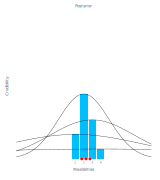

In [6]:
ticks = [1, 2, 3, 4] #specify the tick marks

#create some data for the bars
x5 = DataFrame(Possibilities = 1, Credibility = pdf(Normal(1, 8), 1))
x6 = DataFrame(Possibilities = 2, Credibility = pdf(Normal(2, 3), 2))
x7 = DataFrame(Possibilities = 3, Credibility = pdf(Normal(3, 5), 3))
x8 = DataFrame(Possibilities = 4, Credibility = pdf(Normal(4, 20), 4))
x9 = DataFrame(Possibilities = [1.75, 2.25, 2.75], Credibility = zeros(3))

plot(layer(x5, x = :Possibilities, y = :Credibility, Geom.bar(orientation = :vertical)),
    layer(x6, x = :Possibilities, y = :Credibility, Geom.bar(orientation = :vertical)),
    layer(x7, x = :Possibilities, y = :Credibility, Geom.bar(orientation = :vertical)),
    layer(x8, x = :Possibilities, y = :Credibility, Geom.bar(orientation = :vertical)),
    layer(x->pdf(Normal(1, 8), x), -6, 10, color=[colorant"black"], order=1),
    layer(x->pdf(Normal(2, 3), x), -6, 10, color=[colorant"black"],order=1),
    layer(x->pdf(Normal(3, 5), x), -6, 10, color=[colorant"black"],order=1),
    layer(x->pdf(Normal(4, 20), x), -6, 10, color=[colorant"black"],order=1),
    layer(x9, x = :Possibilities, y = :Credibility, Geom.point, color=[colorant"red"],size =[.2], order=2), #add data
    Guide.xticks(ticks=ticks),
    Guide.yticks(ticks=[]),
    Guide.xlabel("Possibilities"),
    Guide.ylabel("Credibility"),
    Guide.title("Posterior"),
    Coord.Cartesian(ymin=0,ymax=0.3),
     Theme(
        background_color = "white",
        grid_color = "white",
        bar_spacing = 1mm,
        key_position = :none
    ))

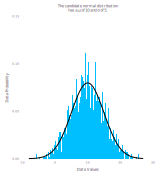

In [7]:
using Random
# set the seed to make the simulation reproducible
Random.seed!(2022) 

# assign d `Normal()` with μ 10 σ = 5 
d = Normal(10,5)
# simulate the data with `rand()` from the specified distribution
simulated_data = DataFrame(x = rand(d, 2000))

#plot it
#Figure 2.4.a.
plot(layer(simulated_data, x=:x, Geom.histogram(density=true)),
    layer(x->pdf(Normal(10, 5), x), -8, 27, color=[colorant"black"],order=1),
    Guide.xlabel("Data Values"),
    Guide.ylabel("Data Probability"),
    Guide.title("The candidate normal distribution\nhas a μ of 10 and σ of 5."),
    Theme(
        background_color = "white",
        grid_color = "white",
        line_width = 1mm
    )
)

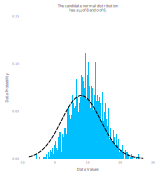

In [8]:
#Figure 2.4.b.
plot(layer(simulated_data, x=:x, Geom.histogram(density=true)),
    layer(x->pdf(Normal(8, 6), x), -8, 27, color=[colorant"black"],order=1),
    Guide.xlabel("Data Values"),
    Guide.ylabel("Data Probability"),
    Guide.title("The candidate normal distribution\nhas a μ of 8 and σ of 6."),
    Theme(
        background_color = "white",
        grid_color = "white",
        line_style = [:dash],
        line_width = 1mm
    )
)

In [9]:
using Distributions, Random, DataFrames, StatsBase

function HtWtDataGenerator(nSubj, rndsd = nothing, maleProb = 0.50) 
    # Random height, weight generator for males and females. Uses parameters from
    # Brainard, J. & Burmaster, D. E. (1992). Bivariate distributions for height and
    # weight of men and women in the United States. Risk Analysis, 12(2), 267-275.
    # Kruschke, J. K. (2011). Doing Bayesian data analysis:
    # A Tutorial with R and BUGS. Academic Press / Elsevier.
    # Kruschke, J. K. (2014). Doing Bayesian data analysis, 2nd Edition:
    # A Tutorial with R, JAGS and Stan. Academic Press / Elsevier.
    
    # Specify parameters of multivariate normal (MVN) distributions.
  
    # Men:
    HtMmu   = 69.18
    HtMsd   = 2.87
    lnWtMmu = 5.14
    lnWtMsd = 0.17
    Mrho    = 0.42
    Mmean   = [HtMmu, lnWtMmu]
    Msigma  = [HtMsd^2 Mrho * HtMsd * lnWtMsd; Mrho * HtMsd * lnWtMsd lnWtMsd^2]
    # Women cluster 1:
    HtFmu1   = 63.11
    HtFsd1   = 2.76
    lnWtFmu1 = 5.06
    lnWtFsd1 = 0.24
    Frho1    = 0.41
    prop1    = 0.46
    Fmean1   = [HtFmu1, lnWtFmu1]
    Fsigma1  = [HtFsd1^2 Frho1 * HtFsd1 * lnWtFsd1; Frho1 * HtFsd1 * lnWtFsd1  lnWtFsd1^2]
    # Women cluster 2:
    HtFmu2   = 64.36
    HtFsd2   = 2.49
    lnWtFmu2 = 4.86
    lnWtFsd2 = 0.14
    Frho2    = 0.44
    prop2    = 1 - prop1
    Fmean2   = [HtFmu2, lnWtFmu2]
    Fsigma2  = [HtFsd2^2  Frho2 * HtFsd2 * lnWtFsd2; Frho2 * HtFsd2 * lnWtFsd2  lnWtFsd2^2]

    # Randomly generate data values from those MVN distributions.
    if rndsd !== nothing 
        Random.seed!(rndsd) 
    end
    datamatrix =  DataFrame(zeros(nSubj, 3), ["male", "height", "weight"])
    # arbitrary coding values
    maleval = 1
    femaleval = 0

    for i in 1:nSubj
        # Flip coin to decide sex
        sex = wsample([maleval, femaleval], [maleProb, 1 - maleProb], 1)

        if sex[1] == maleval
            datum = rand(MvNormal(Mmean, Msigma))
        elseif sex[1] == femaleval
            Fclust = wsample([1, 2], [prop1, prop2], 1)

            if Fclust[1] == 1
            datum = rand(MvNormal(Fmean1, Fsigma1))
            else
            datum = rand(MvNormal(Fmean2, Fsigma2))
            end
        end
        datum[2] = exp(datum[2])
        datamatrix[i, :] = [sex; round.(datum, digits = 1)]
    end

    return datamatrix

end

HtWtDataGenerator (generic function with 3 methods)

In [10]:
#| warning: false
#| echo: false

# set your seed to make the data generation reproducible
Random.seed!(2022) 

d = HtWtDataGenerator(57, 2022, 0.5)

first(d,5)

,male,height,weight
,Float64,Float64,Float64
1,1.0,66.0,141.2
2,0.0,60.4,104.3
3,0.0,62.7,139.4
4,0.0,61.7,109.9
5,1.0,64.4,162.5


In [11]:
#| warning: false

using Turing
using Optim
using MCMCChains, Plots, StatsPlots, Gadfly
using AbstractMCMC
# Define the model
# linear regression.
@model function linear_regression(x,y)
    n = length(y)

    # Set variance prior.
    σ ~  Truncated(Cauchy(0,10),0,Inf)
    # Set intercept prior.
    α ~ Normal(0,100)
    # Set the prior for beta.
    β  ~ Normal(0,100)

    for i in 1:n
        y[i] ~ Normal(α + β * x[i], σ)
    end

    return y
end

#to be concrete we assign the values to x and y
x = d.height
y = d.weight

model = linear_regression(x, y)

#  Run sampler, collect results
chain_lin_reg = sample(model, NUTS(500, 0.65),MCMCDistributed(),2_000, 4);

┌ Warning: Only a single process available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /Users/kiantefernandez/.julia/packages/AbstractMCMC/fnRmh/src/sample.jl:400
┌ Info: Found initial step size
│   ϵ = 0.0125
└ @ Turing.Inference /Users/kiantefernandez/.julia/packages/Turing/szPqN/src/inference/hmc.jl:191
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/kiantefernandez/.julia/packages/AdvancedHMC/51xgc/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/kiantefernandez/.julia/packages/AdvancedHMC/51xgc/src/hamiltonian.jl:47
┌ Info: Found initial step size
│   ϵ = 0.003125
└ @ Turing.Inference /Users/kiantefernandez/.julia/packages/Turing/szPqN/src/inference/hmc.jl:191
Sampling (1 processes):  50%|█████████████▌             |  ETA: 0:00:

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/kiantefernandez/.julia/packages/AdvancedHMC/51xgc/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/kiantefernandez/.julia/packages/AdvancedHMC/51xgc/src/hamiltonian.jl:47
┌ Info: Found initial step size
│   ϵ = 0.0001953125
└ @ Turing.Inference /Users/kiantefernandez/.julia/packages/Turing/szPqN/src/inference/hmc.jl:191
Sampling (1 processes):  75%|████████████████████▎      |  ETA: 0:00:01┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/kiantefernandez/.julia/packages/AdvancedHMC/51xgc/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfin

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/kiantefernandez/.julia/packages/AdvancedHMC/51xgc/src/hamiltonian.jl:47
┌ Info: Found initial step size
│   ϵ = 0.0001953125
└ @ Turing.Inference /Users/kiantefernandez/.julia/packages/Turing/szPqN/src/inference/hmc.jl:191
Sampling (1 processes): 100%|███████████████████████████| Time: 0:00:03


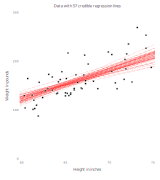

In [12]:
#store in a Dataframe
plot_df = DataFrame(sample(chain_lin_reg[:,:,:], 57))
plot_df.x = x
plot_df.y = y

#plot
abline = Geom.abline(color="red", style=:dash)
Gadfly.plot(plot_df,
    x=:x, y=:y, Geom.point,color = [colorant"black"], intercept=:α, slope=:β, abline, 
    Guide.xlabel("Height in inches"),
    Guide.ylabel("Weight in pounds"),
    Guide.title("Data with 57 credible regression lines"),
    Theme(
        background_color = "white",
        grid_color = "white",
        line_style = [:dash],
        line_width = .1mm
    ))

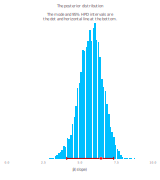

In [13]:
df = DataFrame(chain_lin_reg)

plt_HDI = DataFrame(quantile(group(chain_lin_reg, :β)))
plt_HDI.β .= mode(chain_lin_reg[:,:β,:])

plot(layer(df, x=:β, Geom.histogram(bincount = 50)),
    layer(plt_HDI, x = :β,xmin="2.5%", xmax="97.5%",Geom.point, Geom.errorbar, color=[colorant"red"],size =[.1], order=1),
    Guide.xlabel("β(slope)"),
    Guide.title("The posterior distribution \n
    The mode and 95% HPD intervals are\nthe dot and horizontal line at the bottom."),
    Guide.yticks(ticks=[]),
    Theme(
        background_color = "white",
        grid_color = "white", 
        bar_spacing = 0.25mm,
        line_width = 1mm
))

In [14]:
# extract the posterior draws
# model_pred = linear_regression(x,Vector{Missing}(missing, length(y)))
# posterior_check = predict(model_pred, chain_lin_reg)

In [15]:
Pkg.status()

      Status `~/.julia/environments/v1.7/Project.toml`
  [80f14c24] AbstractMCMC v4.1.3
  [c7e460c6] ArgParse v1.1.4
  [c52e3926] Atom v0.12.38
  [76274a88] Bijectors v0.10.6
  [e28b5b4c] Bootstrap v2.3.3
  [336ed68f] CSV v0.10.4
  [a81c6b42] Compose v0.9.4
  [a93c6f00] DataFrames v1.3.4
  [1313f7d8] DataFramesMeta v0.12.0
  [864edb3b] DataStructures v0.18.13
  [31c24e10] Distributions v0.25.70
  [c91e804a] Gadfly v1.3.4
  [c27321d9] Glob v1.3.0
  [7073ff75] IJulia v1.23.3
  [e5e0dc1b] Juno v0.8.4
  [c7f686f2] MCMCChains v5.3.1
  [c03570c3] Memoize v0.4.4
  [a15396b6] OnlineStats v1.5.14
  [429524aa] Optim v1.7.2
  [d96e819e] Parameters v0.12.3
  [91a5bcdd] Plots v1.31.7
  [1fd47b50] QuadGK v2.5.0
  [295af30f] Revise v3.4.0
  [ed01d8cd] Sobol v1.5.0
  [03a91e81] SplitApplyCombine v1.2.2
  [90137ffa] StaticArrays v1.5.6
  [2913bbd2] StatsBase v0.33.21
  [4c63d2b9] StatsFuns v1.0.1
  [f3b207a7] StatsPlots v0.14.34
  [fd094767] Suppressor v0.2.1
  [bd369af6] Tables v1.7.0
  [fce5fe82] Tur